In [29]:
import tensorflow as tf
from utils import actomyosin_data, plot64
from model.autoencoder_3d_xy48_t8 import AE
from train_utils.autoencoder import AETrain, VAETrain, CVAETrain
import time
import argparse
from datetime import datetime
from packaging import version
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import tifffile
import os
import warnings
from itertools import cycle, islice

from skimage.transform import resize
from skimage.io import imsave, imread

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [30]:
net_type = 'simple'
latent_dim = 12
train_buf = 12000
batch_size =512

model_ID = 'ACTO_AE_flow_4cells_slow_ld12_ntsimple_bs512_2024092309'

# Create a new model instance
model = AE(latent_dim, net_type=net_type)

# Restore the weights
model.load_weights('./checkpoints/'+model_ID+'/')

In [31]:
data_dir = '/mnt/d/lding/actomyosin/data/partitioned_data/VidS1_ps48_flows2_thp1_dense_regular'

patch_size = 48
time_segment = 8

filenames = [x for x in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, x)) and ('.tif' in x)]
filenames.sort()


for filename_ind in range(len(filenames)):
    filename = filenames[filename_ind] 
             
    alltest_img = tifffile.imread(os.path.join(data_dir,filename))

    alltest_img = alltest_img - alltest_img.min()
    alltest_img = alltest_img/alltest_img.max()
    
    movie_len = alltest_img.shape[0]   
    small_alltest_img = alltest_img[0:movie_len,0:patch_size,0:patch_size]
    
    if(filename_ind == 0):
        print(alltest_img.shape)
        time_seg_per_movie = movie_len-time_segment - 1 
        time_seg_per_movie_test1 = time_seg_per_movie
        num_of_samples = len(filenames)*time_seg_per_movie
        alltest_images = np.zeros([num_of_samples, time_segment, patch_size, patch_size ])
        alltest_labels= np.zeros([num_of_samples])

       
    for ti in range(0,time_seg_per_movie):           
        alltest_images[filename_ind*time_seg_per_movie + ti,:,:,:] = small_alltest_img[ti:ti+time_segment,:,:]
        alltest_labels[filename_ind*time_seg_per_movie + ti] = int(filename[1:5]+filename[6:10]+str(ti).zfill(2)+'1')


alltest_images = alltest_images[0:min(len(filenames)*time_seg_per_movie,train_buf),:,:,:]

alltest_images = alltest_images.reshape(alltest_images.shape[0],time_segment, patch_size, patch_size, 1).astype('float32')

(61, 48, 48)


In [32]:
filename

'x0695y0667ps48.tif'

In [33]:
alltest_images.shape
len_1 = alltest_images.shape[0]

In [34]:
data_dir = '/mnt/d/lding/actomyosin/data/partitioned_data/VidS4_BlebWO_stabilized_not17_ps48_flows2_thp1_dense_regular'

patch_size = 48
time_segment = 8

filenames = [x for x in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, x)) and ('.tif' in x)]
filenames.sort()


for filename_ind in range(len(filenames)):
    filename = filenames[filename_ind] 
             
    alltest_img = tifffile.imread(os.path.join(data_dir,filename))

    alltest_img = alltest_img - alltest_img.min()
    alltest_img = alltest_img/alltest_img.max()
    
    movie_len = alltest_img.shape[0]   
    small_alltest_img = alltest_img[0:movie_len,0:patch_size,0:patch_size]
    
    if(filename_ind == 0):
        # print(alltest_img.shape)
        time_seg_per_movie = movie_len-time_segment - 1 
        time_seg_per_movie_test2 = time_seg_per_movie
        num_of_samples = len(filenames)*time_seg_per_movie
        alltest_images_test2 = np.zeros([num_of_samples, time_segment, patch_size, patch_size ])
        alltest_labels_test2= np.zeros([num_of_samples])

       
    for ti in range(0,time_seg_per_movie):           
        alltest_images_test2[filename_ind*time_seg_per_movie + ti,:,:,:] = small_alltest_img[ti:ti+time_segment,:,:]
        alltest_labels_test2[filename_ind*time_seg_per_movie + ti] = int(filename[1:5]+filename[6:10]+str(ti).zfill(2)+'1')


alltest_images_test2 = alltest_images_test2[0:min(len(filenames)*time_seg_per_movie,train_buf),:,:,:]

alltest_images_test2 = alltest_images_test2.reshape(alltest_images_test2.shape[0],time_segment, patch_size, patch_size, 1).astype('float32')

In [35]:
alltest_images_test2.shape

(12000, 8, 48, 48, 1)

In [36]:
len_2 = alltest_images_test2.shape[0]

In [37]:
alltest_images = np.concatenate([alltest_images,alltest_images_test2])
alltest_labels = np.concatenate([alltest_labels,alltest_labels_test2])

In [38]:
alltest_images.shape

(19280, 8, 48, 48, 1)

In [39]:
data_dir = '/mnt/d/lding/actomyosin/data/partitioned_data/media-2-2_ps48_flows2_thp1_dense_regular'

patch_size = 48
time_segment = 8

filenames = [x for x in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, x)) and ('.tif' in x)]
filenames.sort()


for filename_ind in range(len(filenames)):
    filename = filenames[filename_ind] 
             
    alltest_img = tifffile.imread(os.path.join(data_dir,filename))

    alltest_img = alltest_img - alltest_img.min()
    alltest_img = alltest_img/alltest_img.max()
    
    movie_len = alltest_img.shape[0]   
    small_alltest_img = alltest_img[0:movie_len,0:patch_size,0:patch_size]
    
    if(filename_ind == 0):
        print(alltest_img.shape)
        time_seg_per_movie = movie_len-time_segment - 1 
        time_seg_per_movie_test3 = time_seg_per_movie
        num_of_samples = len(filenames)*time_seg_per_movie
        alltest_images_test3 = np.zeros([num_of_samples, time_segment, patch_size, patch_size ])
        alltest_labels_test3= np.zeros([num_of_samples])

       
    for ti in range(0,time_seg_per_movie):           
        alltest_images_test3[filename_ind*time_seg_per_movie + ti,:,:,:] = small_alltest_img[ti:ti+time_segment,:,:]
        alltest_labels_test3[filename_ind*time_seg_per_movie + ti] = int(filename[1:5]+filename[6:10]+str(ti).zfill(2)+'1')


alltest_images_test3 = alltest_images_test3[0:min(len(filenames)*time_seg_per_movie,train_buf),:,:,:]

alltest_images_test3 = alltest_images_test3.reshape(alltest_images_test3.shape[0],time_segment, patch_size, patch_size, 1).astype('float32')

(61, 48, 48)


In [40]:
alltest_images_test3.shape


(2756, 8, 48, 48, 1)

In [41]:
len_3 = alltest_images_test3.shape[0]

In [42]:
alltest_images = np.concatenate([alltest_images,alltest_images_test3])
alltest_labels = np.concatenate([alltest_labels,alltest_labels_test3])

In [43]:
alltest_images.shape

(22036, 8, 48, 48, 1)

In [44]:
# train_images_flip = train_images[:,:,::-1,::-1,:]
# train_images = np.concatenate([train_images,train_images_flip])
# train_labels = np.concatenate([train_labels,train_labels+100000000])

In [45]:
# train_images_swap = train_images.swapaxes(2, 3)
# train_images = np.concatenate([train_images,train_images_swap])
# train_labels = np.concatenate([train_labels,train_labels+1000000000])

In [46]:
TRAIN_BUF = train_buf
BATCH_SIZE = batch_size

alltest_dataset_image = tf.data.Dataset.from_tensor_slices(alltest_images).batch(BATCH_SIZE)
alltest_dataset_label = tf.data.Dataset.from_tensor_slices(alltest_labels).batch(BATCH_SIZE)
alltest_dataset = tf.data.Dataset.zip((alltest_dataset_image, alltest_dataset_label)).shuffle(TRAIN_BUF)

In [47]:
flag_sample = 1

for x_input, y_input in alltest_dataset:
    if flag_sample == 1:        
        z = model.encode(x_input)
        Z_array = z.numpy()
        flag_sample = 0
    else:
        z = model.encode(x_input)
        Z_array = np.concatenate((Z_array,z.numpy()), axis=0)
        

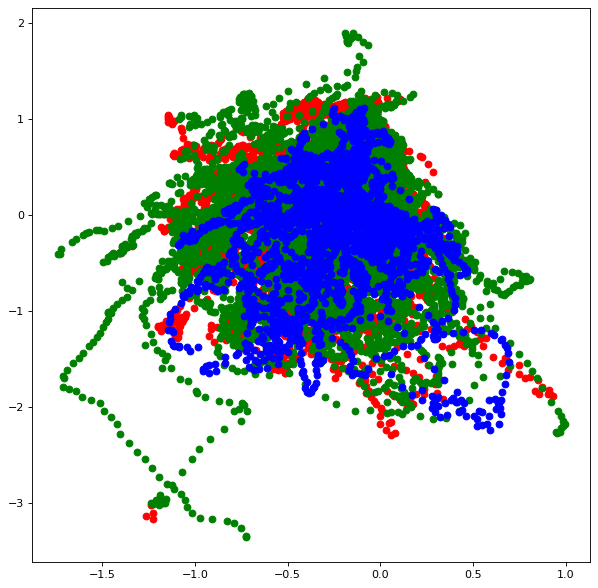

In [61]:
fig = plt.figure(figsize=(9,9), dpi=80)

nc1 = 0
nc2 = 1
nc3 = 2


ax = fig.add_subplot()
ax.scatter(
    Z_array[0:len_1, nc1],
    Z_array[0:len_1, nc2],c='red')    
ax.scatter(
    Z_array[len_1:len_1+len_2, nc1],
    Z_array[len_1:len_1+len_2, nc2],c='green')  
ax.scatter(
    Z_array[len_1+len_2:, nc1],
    Z_array[len_1+len_2:, nc2],c='blue')  
 


In [53]:
len_1+len_2

19280

In [54]:
os.mkdir("/mnt/d/lding/actomyosin/ACTO_xyz3D_flow123x_results/ACTO_AE_flow_4cells_slow_ld12_ntsimple_bs512_2024092309")
os.mkdir("/mnt/d/lding/actomyosin/ACTO_xyz3D_flow123x_results/ACTO_AE_flow_4cells_slow_ld12_ntsimple_bs512_2024092309/trac")

FileExistsError: [Errno 17] File exists: '/mnt/d/lding/actomyosin/ACTO_xyz3D_flow123x_results/ACTO_AE_flow_4cells_slow_ld12_ntsimple_bs512_2024092309'

KeyboardInterrupt: 

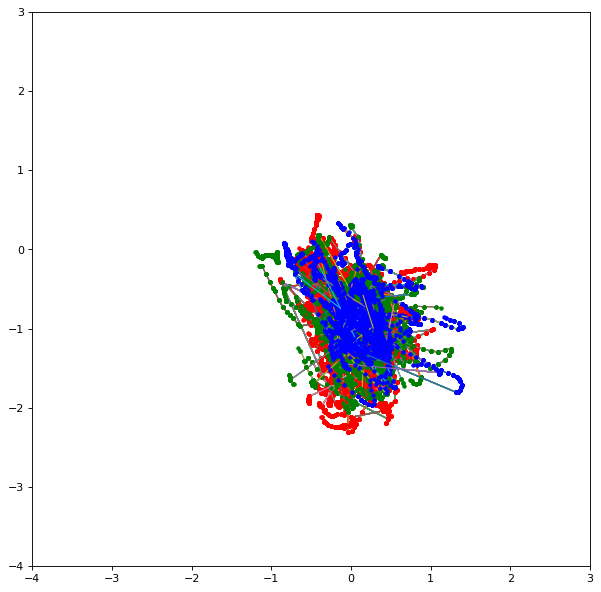

In [51]:
fig = plt.figure(figsize=(9,9), dpi=80)
ax = fig.add_subplot()
for j in range(0,max([time_seg_per_movie_test1,time_seg_per_movie_test2,time_seg_per_movie_test3])):

    if(j<time_seg_per_movie_test1):
        for i in range(int(len_1/time_seg_per_movie_test1)):
            ax.plot(Z_array[i*time_seg_per_movie_test1:i*time_seg_per_movie_test1+j, 0],Z_array[i*time_seg_per_movie_test1:i*time_seg_per_movie_test1+j, 1],linewidth=1)
            ax.plot(Z_array[i*time_seg_per_movie_test1:i*time_seg_per_movie_test1+j, 0],Z_array[i*time_seg_per_movie_test1:i*time_seg_per_movie_test1+j, 1],'r.')

    if(j<time_seg_per_movie_test2):
        for i in range(int(len_2/time_seg_per_movie_test2)):
            ax.plot(Z_array[len_1 + i*time_seg_per_movie_test2:len_1 + i*time_seg_per_movie_test2+j, 0],Z_array[len_1 + i*time_seg_per_movie_test2:len_1 + i*time_seg_per_movie_test2+j, 1],linewidth=1)
            ax.plot(Z_array[len_1 + i*time_seg_per_movie_test2:len_1 + i*time_seg_per_movie_test2+j, 0],Z_array[len_1 + i*time_seg_per_movie_test2:len_1 + i*time_seg_per_movie_test2+j, 1],'g.')

    if(j<time_seg_per_movie_test3):
        for i in range(int(len_1/time_seg_per_movie_test1)):
            ax.plot(Z_array[len_1 + len_2 + i*time_seg_per_movie_test3:len_1 + len_2 + i*time_seg_per_movie_test3+j, 0],Z_array[len_1 + len_2 + i*time_seg_per_movie_test3:len_1 + len_2 + i*time_seg_per_movie_test3+j, 1],linewidth=1)
            ax.plot(Z_array[len_1 + len_2 + i*time_seg_per_movie_test3:len_1 + len_2 + i*time_seg_per_movie_test3+j, 0],Z_array[len_1 + len_2 + i*time_seg_per_movie_test3:len_1 + len_2 + i*time_seg_per_movie_test3+j, 1],'b.')


    ax.set_xlim(-4,3)
    ax.set_ylim(-4,3)
    plt.savefig('/mnt/d/lding/actomyosin/ACTO_xyz3D_flow123x_results/ACTO_AE_flow_4cells_slow_ld12_ntsimple_bs512_2024092309/trac/'
            +'traj_t%d'% (j))
    